## 시니어

- DQN 코드 작성 (전에 성능 나왔으면, DDQN 구현)  
- 먼저 (5,5)와 같이 작은 사이즈의 환경에서 시작  
- 매직넘버 사용 지양  



---  


### 1. **작은 사이즈, 적은 지뢰 밀도** 환경에서 학습되는지 확인  

### 시니어용 세팅

In [55]:
! git clone "https://github.com/KanghwaSisters/DQN_minesweeper.git"

fatal: destination path 'DQN_minesweeper' already exists and is not an empty directory.


In [56]:
import os
os.chdir('/content/DQN_minesweeper/codes/Environment')

In [57]:
! python reward5.py
from reward5 import *

In [58]:
env = MinesweeperEnv(map_size=(5,5),
                     n_mines=5,
                     rewards={'win':1, 'lose':-1, 'progress':0.3, 'guess':0.3, 'no_progress' : -1},
                     dones={'win':True, 'lose':True, 'progress':False, 'guess':False, 'no_progress' : False},
                     dim2=True)

## 주니어

1. 레버 환경 만들기  
2. 카트폴 예제 -- 속도 개선, 학습 가능하게 만들기  
3. 매직 넘버 줄이기
4. 중간 중간 디버깅하면서 가기(구현 단위 별로 테스트)

### 1. 레버 환경 만들기

3개의 레버가 있다.  
- 1번 레버를 당겼을 때 바나나가 떨어질 확률이 0.7, 아무 것도 떨어지지 않을 확률이 0.3  
- 2번 레버를 당겼을 때 바나나가 떨어질 확률이 0.1, 상한 바나나 껍질만 떨어질 확률이 0.8, 아무 것도 떨어지지 않을 확률이 0.1  
- 3번 레버를 당겼을 때 상한 바나나 껍질만 떨어질 확률이 0.5, 아무 것도 떨어지지 않을 확률이 0.5  



1. 상태를 표현하는 방법   
2. 보상 구조 설계  
3. 한 번 행동 한 후 초기화하는 걸 전제    
4. 환경 로직 설계

In [59]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

In [60]:
class LeverEnv:
    def __init__(self):
        self.state_size = 3
        self.action_size = 3

    def step(self, action):
        # action에 맞게 next_state가 변화
        # 바나나: [1, 0, 0], 아무 것도 X: [0, 1, 0], 상한 바나나: [0, 0, 1]

        done = True

        if action == 1:
            next_state, reward = self.pull_lever1()
        elif action == 2:
            next_state, reward = self.pull_lever2()
        elif action == 3:
            next_state, reward = self.pull_lever3()
        else:
            next_state, reward = [0, 1, 0], 0 # default case (정확하지 않은 action)

        return next_state, reward, done

    def reset(self):
        state = [0, 0, 0]
        return state

    def render(self):
        if self.next_state == [1, 0, 0]:
            print("바나나 획득!")
        elif self.next_state == [0, 1, 0]:
            print("아무 것도 없음.")
        elif self.next_state == [0, 0, 1]:
            print("상한 바나나 껍질...")

    # if문 간단하게 재작성
    def pull_lever1(self):
        if np.random.rand() < 0.7:
            return [1, 0, 0], 1  # 바나나
        return [0, 1, 0], 0  # 아무 것도 X

    def pull_lever2(self):
        rand = np.random.rand()
        if rand < 0.1:
            next_state = [0, 1, 0]  # 아무 것도 X
            reward = 0
        elif rand < 0.9:
            next_state = [0, 0, 1]  # 상한 바나나
            reward = -5
        else:
            next_state = [1, 0, 0]  # 바나나
            reward = 1
        return next_state, reward

    def pull_lever3(self):
        if np.random.rand() < 0.5:
            return [0, 1, 0], 0  # 아무 것도 X
        return [0, 0, 1], -5  # 상한 바나나


In [61]:
class DQN(nn.Module):
    def __init__(self, input_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q = self.fc3(x)
        return q

In [62]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.gamma = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        self.target_update_freq = 10

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

        # 타깃 모델 초기화
        self.update_target_model()

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        else:
            q_value = self.model(state)
            return np.argmax(q_value)

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

            mini_batch = random.sample(self.memory, self.batch_size)

            states = np.array([sample[0] for sample in mini_batch])
            actions = np.array([sample[1] for sample in mini_batch])
            rewards = np.array([sample[2] for sample in mini_batch])
            next_states = np.array([sample[3] for sample in mini_batch])
            dones = np.array([sample[4] for sample in mini_batch])

            predicts = self.model(torch.FloatTensor(states))
            target_predicts = self.target_model(torch.FloatTensor(next_states))

            targets = rewards + (1 - dones) * self.gamma * target_predicts.max(1)[0].detach().numpy()
            predicts = predicts.gather(1, torch.LongTensor(actions).unsqueeze(1)).squeeze(1)

            # 다음 상태에 대한 타깃 모델의 큐함수
            with torch.no_grad():
                target_predicts = self.target_model(torch.tensor(next_states, dtype=torch.float32))

            # 벨만 최적 방정식을 이용한 업데이트 타깃
            max_q = np.amax(target_predicts, dim=1)[0]
            targets = torch.tensor(rewards) + (1-torch.tensor(dones, dtype=torch.float32)) * self.gamma * max_q


            loss = self.criterion(targets - predicts)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

episode:   0 | score avg: 0.00 | memory length:    1 | epsilon: 1.0000
episode:   1 | score avg: 0.00 | memory length:    2 | epsilon: 1.0000
episode:   2 | score avg: 0.00 | memory length:    3 | epsilon: 1.0000
episode:   3 | score avg: -5.00 | memory length:    4 | epsilon: 1.0000
episode:   4 | score avg: 0.00 | memory length:    5 | epsilon: 1.0000
episode:   5 | score avg: 0.00 | memory length:    6 | epsilon: 1.0000
episode:   6 | score avg: 0.00 | memory length:    7 | epsilon: 1.0000
episode:   7 | score avg: 0.00 | memory length:    8 | epsilon: 1.0000
episode:   8 | score avg: 1.00 | memory length:    9 | epsilon: 1.0000
episode:   9 | score avg: 0.00 | memory length:   10 | epsilon: 1.0000
episode:  10 | score avg: -5.00 | memory length:   11 | epsilon: 1.0000
episode:  11 | score avg: 1.00 | memory length:   12 | epsilon: 1.0000
episode:  12 | score avg: 1.00 | memory length:   13 | epsilon: 1.0000
episode:  13 | score avg: 1.00 | memory length:   14 | epsilon: 1.0000
epis

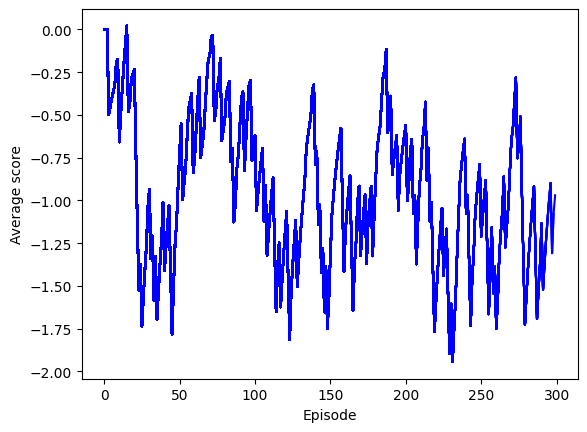

In [64]:
if __name__ == "__main__":
    env = LeverEnv()
    state_size = env.state_size
    action_size = env.action_size

    # DQN 에이전트 생성
    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []
    score_avg = 0

    num_episode = 300
    for e in range(num_episode):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size]) #?

        while not done:
            if agent.render:
                env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            # 타임스텝마다 보상 0.1, 에피소드 중간에 끝나면 -1 보상
            score += reward
            reward = 0.1 if not done else -1

            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)
            # 타임스텝마다 학습
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            state = next_state

            if done:
                # 에피소드마다 학습 결과 출력
                score_avg = 0.9 * score_avg + 0.1 * score
                print("episode: {:3d} | score avg: {:3.2f} | memory length: {:4d} | epsilon: {:.4f}".format(
                    e, score, len(agent.memory), agent.epsilon))

                if e % agent.target_update_freq == 0:
                    agent.update_target_model()

                # 에피소드마다 학습 결과 그래프로 저장
                scores.append(score_avg)
                episodes.append(e)
                plt.plot(episodes, scores, 'b')
                plt.xlabel('Episode')
                plt.ylabel('Average score')

                # 평균 점수가 400 이상일 때 종료
                if score_avg > 400:
                    torch.save(agent.model.state_dict(), "./save_model/model.pth")
                    break

## 과제
1. 완성해오기(설명가능한 상태로 ipynb 파일 구성)    
2. 알파제로 구조 공부해오기(전원)  
3. 자기 코드 규칙 정리해오기